### Importing Libraries

In [146]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import top_k_categorical_accuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

### Constants

In [147]:
batch_size = 32
num_classes = 124
tf.random.set_seed(42)
img_height, img_width = 128, 128
data_dir = os.path.join(os.getcwd(), "../5-Gait-Energy-Images")

### Training Data Augmentation

In [148]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.15
)

### Testing Data Augmentation

In [149]:
test_datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.15)

### Load and split data into training and testing sets

In [150]:
train_generator = train_datagen.flow_from_directory(
    data_dir,
    seed=42,
    shuffle=True,
    subset="training",
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode="categorical",
    target_size=(img_height, img_width),
)

test_generator = test_datagen.flow_from_directory(
    data_dir,
    seed=42,
    shuffle=False,
    subset="validation",
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode="categorical",
    target_size=(img_height, img_width),
)

Found 11587 images belonging to 124 classes.
Found 1974 images belonging to 124 classes.


### GaitNet Model

In [151]:
def custom_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # Initial convolutional layer
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Residual blocks (ResNet inspired)
    x = residual_block(x, 64)
    x = layers.MaxPooling2D((2, 2))(x)

    x = residual_block(x, 128)
    x = layers.MaxPooling2D((2, 2))(x)

    x = residual_block(x, 256)

    # Transition block
    x = transition_block(x, 128)

    # EfficientNetB0 block
    x = efficient_block(x, 256)

    # InceptionNet block
    x = inception_block(x, 128)

    # Global average pooling
    x = layers.Flatten()(x)

    # Fully connected layers
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.BatchNormalization()(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model


def residual_block(x, filters):
    shortcut = x
    x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Adjusting dimensions of shortcut tensor
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(
            filters, (1, 1), activation='relu', padding='same')(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x


def transition_block(x, filters):
    x = layers.Conv2D(filters, (1, 1), activation='relu')(x)
    x = layers.AveragePooling2D((2, 2))(x)
    return x


def efficient_block(x, filters):
    x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    return x


def inception_block(x, filters):
    x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    return x


input_shape = (128, 128, 1)
num_classes = 124  # Number of individuals in your dataset

### Create the model

In [152]:
model = custom_model(input_shape, num_classes)

### Define Top k Accuracy Function

In [153]:
def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

### Compile the model

In [154]:
model.compile(optimizer=RMSprop(
    rho=0.9,
    momentum=0.4,
    epsilon=1e-07,
    name="RMSprop",
    centered=False,
    learning_rate=1e-3,
), loss='categorical_crossentropy',
    metrics=['acc', top_5_accuracy])

### Define the Callbacks

In [155]:
checkpoint = ModelCheckpoint(
    "best_model.h5", monitor='val_acc', save_best_only=True, mode='max')
early_stopping = EarlyStopping(
    monitor='val_acc', patience=40, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(
    monitor='val_acc', factor=0.1, patience=10, min_lr=1e-7)

### Train the model

In [156]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=500,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    use_multiprocessing=True)

Epoch 1/500
363/363 [==============================] - 118s 313ms/step - loss: 4.9712 - acc: 0.0169 - top_5_accuracy: 0.0730 - val_loss: 5.0107 - val_acc: 0.0198 - val_top_5_accuracy: 0.0973 - lr: 0.0010
Epoch 2/500
363/363 [==============================] - 108s 297ms/step - loss: 4.1152 - acc: 0.0667 - top_5_accuracy: 0.2492 - val_loss: 8.3310 - val_acc: 0.0137 - val_top_5_accuracy: 0.0709 - lr: 0.0010
Epoch 3/500
363/363 [==============================] - 111s 305ms/step - loss: 3.4124 - acc: 0.1599 - top_5_accuracy: 0.4433 - val_loss: 4.7151 - val_acc: 0.0496 - val_top_5_accuracy: 0.1793 - lr: 0.0010
Epoch 4/500
363/363 [==============================] - 109s 299ms/step - loss: 2.9013 - acc: 0.2519 - top_5_accuracy: 0.5933 - val_loss: 5.2993 - val_acc: 0.1104 - val_top_5_accuracy: 0.2771 - lr: 0.0010
Epoch 5/500
363/363 [==============================] - 108s 296ms/step - loss: 2.5581 - acc: 0.3212 - top_5_accuracy: 0.6792 - val_loss: 10.7287 - val_acc: 0.0583 - val_top_5_accuracy:

### Evaluate model on training set

In [157]:
train_loss, train_accuracy, top5train = model.evaluate(train_generator)
print(f"Training Loss: {round(train_loss, 2)}")
print(f"Training Accuracy: {round(train_accuracy, 2)}")
print(f"Training Top 5 Accuracy: {round(top5train, 2)}")

363/363 [==============================] - 36s 99ms/step - loss: 2.0351e-04 - acc: 0.9999 - top_5_accuracy: 1.0000
Training Loss: 0.0
Training Accuracy: 1.0
Training Top 5 Accuracy: 1.0


### Evaluate model on testing set

In [158]:
test_loss, test_accuracy, top5test = model.evaluate(test_generator)
print(f"Testing Loss: {round(test_loss, 2)}")
print(f"Testing Accuracy: {round(test_accuracy, 2)}")
print(f"Testing Top 5 Accuracy: {round(top5test, 2)}")

62/62 [==============================] - 6s 102ms/step - loss: 0.4379 - acc: 0.9017 - top_5_accuracy: 0.9757
Testing Loss: 0.44
Testing Accuracy: 0.9
Testing Top 5 Accuracy: 0.98


### Save the model

In [159]:
model.save('../10-Trained-Models/GaitNet.h5')

### Model Summary

In [160]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_155 (Conv2D)         (None, 128, 128, 32)         320       ['input_12[0][0]']            
                                                                                                  
 batch_normalization_116 (B  (None, 128, 128, 32)         128       ['conv2d_155[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 max_pooling2d_57 (MaxPooli  (None, 64, 64, 32)           0         ['batch_normalization_1

### Plot Training & Validation Accuracy

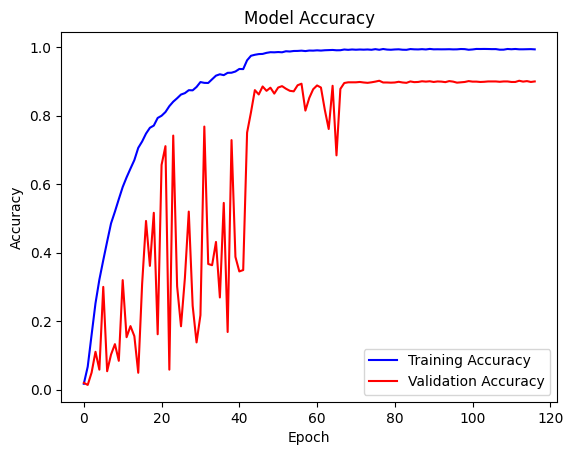

In [161]:
plt.plot(history.history['acc'], color='blue', label='Training Accuracy')
plt.plot(history.history['val_acc'],
         color='red', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Plot Training and Validation Loss

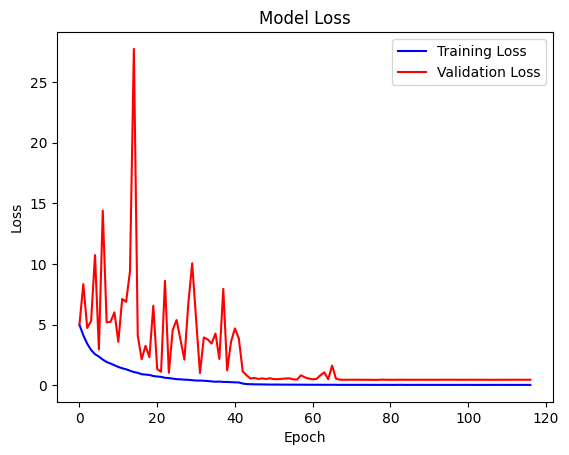

In [162]:
plt.plot(history.history['loss'], color='blue', label='Training Loss')
plt.plot(history.history['val_loss'],
         color='red', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Plot Training and Testing Top 5 Accuracy

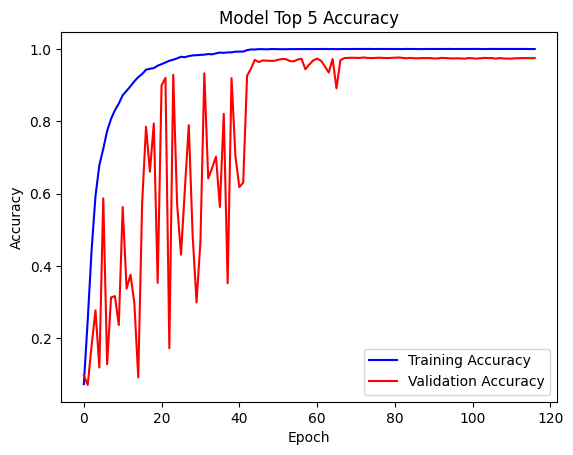

In [163]:
plt.plot(history.history['top_5_accuracy'],
         color='blue', label='Training Accuracy')
plt.plot(history.history['val_top_5_accuracy'],
         color='red', label='Validation Accuracy')
plt.title('Model Top 5 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()